In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, LogLocator
from materialize import MZ_ROOT

In [2]:
# Set grid option globally
plt.rcParams['axes.grid'] = True

Read input file:

In [3]:
df = pd.read_csv(MZ_ROOT / 'results_1745919156.csv')

Compute additional columns

In [4]:
# Remove the scale factor from the scenario name.
df['scenario_name'] = df['scenario'].map(lambda x: x.rsplit('_', 1)[0])
# Cluster replica size as credits/hour
df["credits_per_h"] = df["cluster_size"].str[:-2].astype(int) / 100
# Cluster replica size as centi-credits/s
df["ccredit_per_s"] = df["credits_per_h"] / 3600 * 100
# Number of timely workers
df["workers"] = round(df["credits_per_h"] * 1.9375)
# Throughput in MiB/s
df["throughput_mb_per_s"] = df["size_bytes"] / df["time_ms"] * 1000 / 1024 / 1024
# Throughput in MiB/s/worker
df["throughput_mb_per_s_worker"] = df["size_bytes"] / 1024 / 1024 / df["time_ms"] * 1000 / df["workers"]
# Throughput in MiB/credit
df["throughput_mb_per_credit"] = df["size_bytes"] / 1024 / 1024/ df["time_ms"] * 1000 / df["ccredit_per_s"]
# Cost in centi-credits: ccredit/s * s
df["credit_time"] = df["ccredit_per_s"] * df["time_ms"] / 1000.

In [5]:
df

,scenario,mode,category,test_name,cluster_size,repetition,size_bytes,time_ms,scenario_name,credits_per_h,ccredit_per_s,workers,throughput_mb_per_s,throughput_mb_per_s_worker,throughput_mb_per_credit,credit_time
0,tpcc_sf_10,strong,arrangement_formation,create_index,100cc,0,7400783934,183450,tpcc_sf,1.0,0.027778,2.0,38.473358,19.236679,1.385041e+03,5.095833
1,tpcc_sf_10,strong,peek_serving,peek_index_key_fast_path,100cc,0,7400789951,108,tpcc_sf,1.0,0.027778,2.0,65351.326828,32675.663414,2.352648e+06,0.003000
2,tpcc_sf_10,strong,peek_serving,peek_index_key_fast_path,100cc,1,7400794025,107,tpcc_sf,1.0,0.027778,2.0,65962.123202,32981.061601,2.374636e+06,0.002972
3,tpcc_sf_10,strong,peek_serving,peek_index_key_fast_path,100cc,2,7400797309,107,tpcc_sf,1.0,0.027778,2.0,65962.152472,32981.076236,2.374637e+06,0.002972
4,tpcc_sf_10,strong,peek_serving,peek_index_key_fast_path,100cc,3,7400799776,107,tpcc_sf,1.0,0.027778,2.0,65962.174460,32981.087230,2.374638e+06,0.002972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,auction_1280,weak,primitive_operators,bids_sum,3200cc,0,42435253109,19565,auction,32.0,0.888889,62.0,2068.459545,33.362251,2.327017e+03,17.391111
578,auction_1280,weak,composite_operators,bids_count_max_sum_min,3200cc,0,42437171999,131700,auction,32.0,0.888889,62.0,307.298717,4.956431,3.457111e+02,117.066667
579,auction_1280,weak,primitive_operators,join,3200cc,0,42437412360,17378,auction,32.0,0.888889,62.0,2328.891140,37.562760,2.620003e+03,15.447111
580,auction_1280,weak,composite_operators,join_max,3200cc,0,42440405738,210865,auction,32.0,0.888889,62.0,191.944253,3.095875,2.159373e+02,187.435556


## Show properties of the data

In [6]:
df['scenario'].value_counts()

scenario
auction_40       210
tpcc_mv_sf_10    144
tpcc_sf_10        78
auction_80        30
auction_160       30
auction_320       30
auction_640       30
auction_1280      30
Name: count, dtype: int64

In [7]:
df['mode'].value_counts()

mode
strong    402
weak      180
Name: count, dtype: int64

In [8]:
df['category'].value_counts()

category
peek_serving                   474
arrangement_formation           36
primitive_operators             36
composite_operators             24
materialized_view_formation     12
Name: count, dtype: int64

In [9]:
df['test_name'].value_counts()

test_name
peek_index_key_fast_path                    180
peek_index_key_slow_path                    120
peek_materialized_view_key_slow_path         60
peek_materialized_view_key_fast_path         60
peek_index_non_key_fast_path                 18
index_restart                                18
join_max                                     12
bids_max                                     12
join                                         12
bids_count_max_sum_min                       12
bids_sum                                     12
create_index_primary_key                     12
create_index_foreign_key                     12
peek_index_non_key_slow_path                 12
create_index                                  6
peek_materialized_view_non_key_fast_path      6
peek_materialized_view_non_key_slow_path      6
create_materialize_view                       6
materialized_view_restart                     6
Name: count, dtype: int64

In [10]:
#df2 = df.query('test_name == "join"').pivot(index='credits_per_h', columns=['category', 'test_name', 'mode'], values='time_ms')
df2 = df.query('category != "peek_serving"').pivot(index=['scenario_name', 'credits_per_h'], columns=['category', 'test_name', 'mode'], values=['time_ms']).sort_index(axis=1)
df2

time_ms                           \
category                    arrangement_formation                            
test_name                            create_index create_index_foreign_key   
mode                                       strong                   strong   
scenario_name credits_per_h                                                  
auction       1.0                             NaN                  40796.0   
              2.0                             NaN                  20464.0   
              4.0                             NaN                  10270.0   
              8.0                             NaN                   5288.0   
              16.0                            NaN                   2949.0   
              32.0                            NaN                   1718.0   
tpcc_mv_sf    1.0                             NaN                      NaN   
              2.0                             NaN                      NaN   
              4.0                             NaN                      NaN   
              8.0                             NaN                      NaN   
              16.0                            NaN                      NaN   
              32.0                            NaN                      NaN   
tpcc_sf       1.0                        183450.0                      NaN   
              2.0                         96806.0                      NaN   
              4.0                         57015.0                      NaN   
              8.0                         28397.0                      NaN   
              16.0                        22397.0                      NaN   
              32.0                        14780.0                      NaN   

                                                                        \
category                                                                 
test_name                            create_index_primary_key            
mode                            weak                   strong     weak   
scenario_name credits_per_h                                              
auction       1.0            41234.0                  39070.0  42130.0   
              2.0            40596.0                  24676.0  44173.0   
              4.0            41475.0                  16249.0  46440.0   
              8.0            42984.0                  10379.0  51306.0   
              16.0           46305.0                   9377.0  63343.0   
              32.0           51670.0                   5665.0  82199.0   
tpcc_mv_sf    1.0                NaN                      NaN      NaN   
              2.0                NaN                      NaN      NaN   
              4.0                NaN                      NaN      NaN   
              8.0                NaN                      NaN      NaN   
              16.0               NaN                      NaN      NaN   
              32.0               NaN                      NaN      NaN   
tpcc_sf       1.0                NaN                      NaN      NaN   
              2.0                NaN                      NaN      NaN   
              4.0                NaN                      NaN      NaN   
              8.0                NaN                      NaN      NaN   
              16.0               NaN                      NaN      NaN   
              32.0               NaN                      NaN      NaN   

                                                                            \
category                                     composite_operators             
test_name                   index_restart bids_count_max_sum_min             
mode                               strong                 strong      weak   
scenario_name credits_per_h                                                  
auction       1.0                     NaN               146544.0  149073.0   
              2.0                     NaN                78954.0  130374.0  

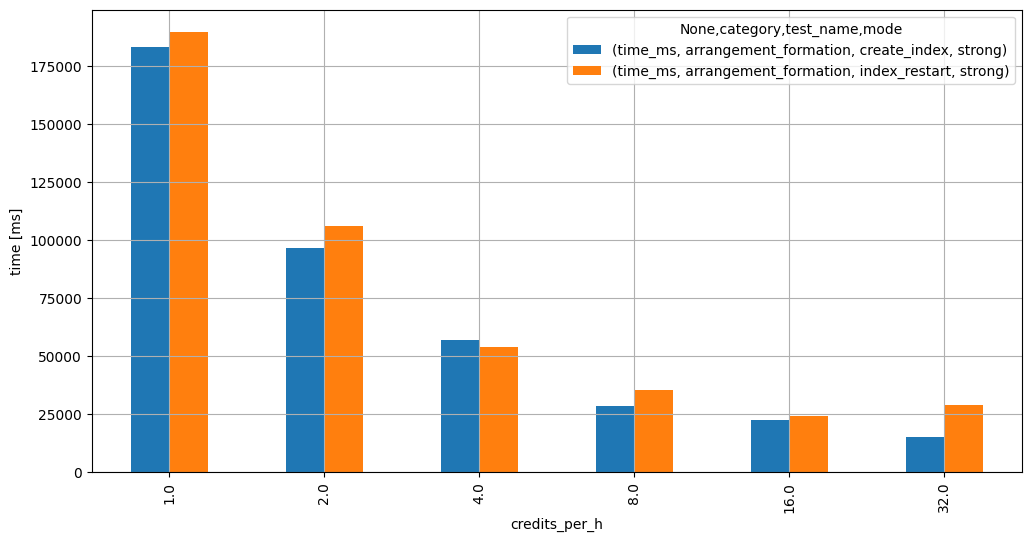

In [11]:
ax = df2.loc['tpcc_sf'].dropna(axis=1, how='all').plot(kind='bar', figsize=(12,6), ylabel='time [ms]', logy=False)

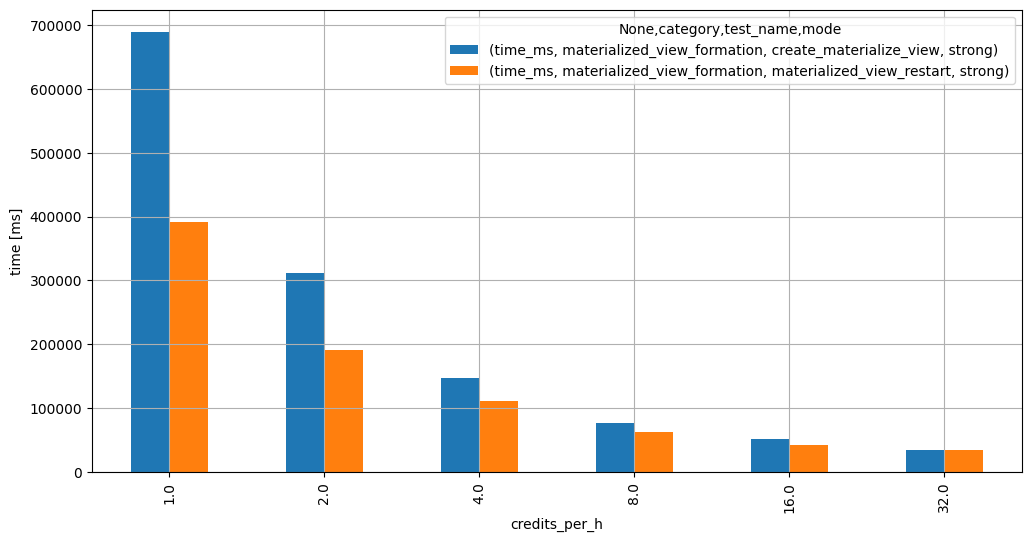

In [12]:
ax = df2.loc['tpcc_mv_sf'].dropna(axis=1, how='all').plot(kind='bar', figsize=(12,6), ylabel='time [ms]', logy=False)

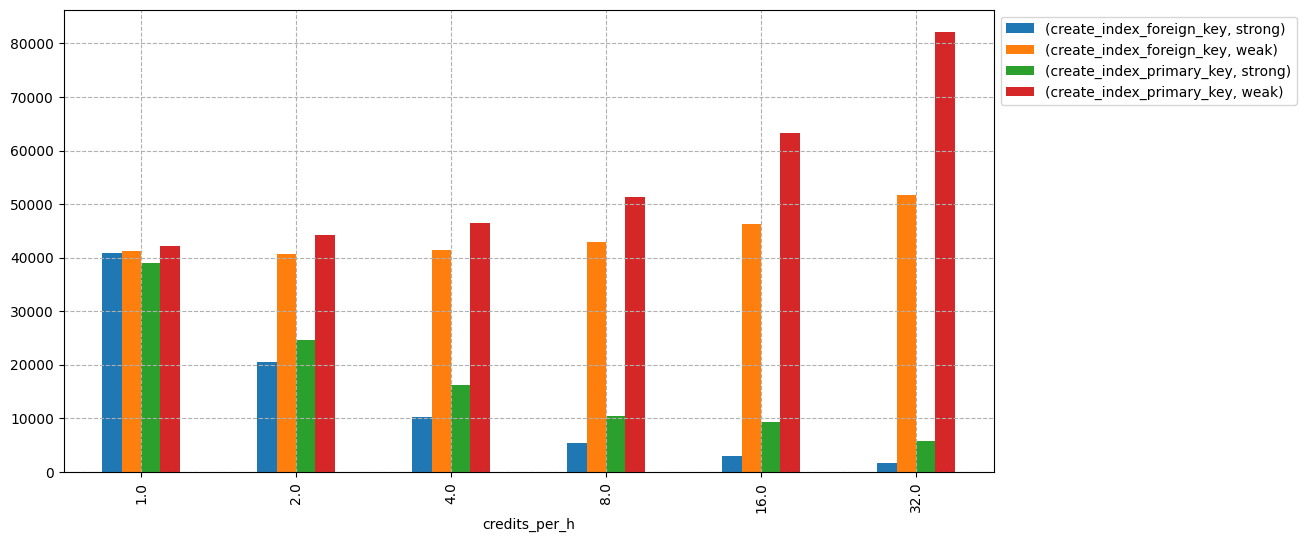

In [13]:
ax = df2.loc[('auction',), ('time_ms', 'arrangement_formation')].dropna(axis=1, how='all').plot(kind='bar', logy=False, figsize=(12,6))
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
#ax.set_ylim(1000)
#ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y):,}'))
#ax.yaxis.set_minor_formatter(FuncFormatter(lambda y, _: f'{int(y):,}'))
#ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=3))
ax.grid(which='both', linestyle='--')

In [14]:
df2 = df.query('category != "peek_serving"').pivot(index=['scenario_name', 'credits_per_h'], columns=['category', 'test_name', 'mode'], values=['credit_time']).sort_index(axis=1)
df2

credit_time                           \
category                    arrangement_formation                            
test_name                            create_index create_index_foreign_key   
mode                                       strong                   strong   
scenario_name credits_per_h                                                  
auction       1.0                             NaN                 1.133222   
              2.0                             NaN                 1.136889   
              4.0                             NaN                 1.141111   
              8.0                             NaN                 1.175111   
              16.0                            NaN                 1.310667   
              32.0                            NaN                 1.527111   
tpcc_mv_sf    1.0                             NaN                      NaN   
              2.0                             NaN                      NaN   
              4.0                             NaN                      NaN   
              8.0                             NaN                      NaN   
              16.0                            NaN                      NaN   
              32.0                            NaN                      NaN   
tpcc_sf       1.0                        5.095833                      NaN   
              2.0                        5.378111                      NaN   
              4.0                        6.335000                      NaN   
              8.0                        6.310444                      NaN   
              16.0                       9.954222                      NaN   
              32.0                      13.137778                      NaN   

                                                                            \
category                                                                     
test_name                              create_index_primary_key              
mode                              weak                   strong       weak   
scenario_name credits_per_h                                                  
auction       1.0             1.145389                 1.085278   1.170278   
              2.0             2.255333                 1.370889   2.454056   
              4.0             4.608333                 1.805444   5.160000   
              8.0             9.552000                 2.306444  11.401333   
              16.0           20.580000                 4.167556  28.152444   
              32.0           45.928889                 5.035556  73.065778   
tpcc_mv_sf    1.0                  NaN                      NaN        NaN   
              2.0                  NaN                      NaN        NaN   
              4.0                  NaN                      NaN        NaN   
              8.0                  NaN                      NaN        NaN   
              16.0                 NaN                      NaN        NaN   
              32.0                 NaN                      NaN        NaN   
tpcc_sf       1.0                  NaN                      NaN        NaN   
              2.0                  NaN                      NaN        NaN   
              4.0                  NaN                      NaN        NaN   
              8.0                  NaN                      NaN        NaN   
              16.0                 NaN                      NaN        NaN   
              32.0                 NaN                      NaN        NaN   

                                                                              \
category                                     composite_operators               
test_name                   index_restart bids_count_max_sum_min               
mode                               strong                 strong        weak   
scenario_name credits_per_h                                                    
auction       1.0                     NaN       

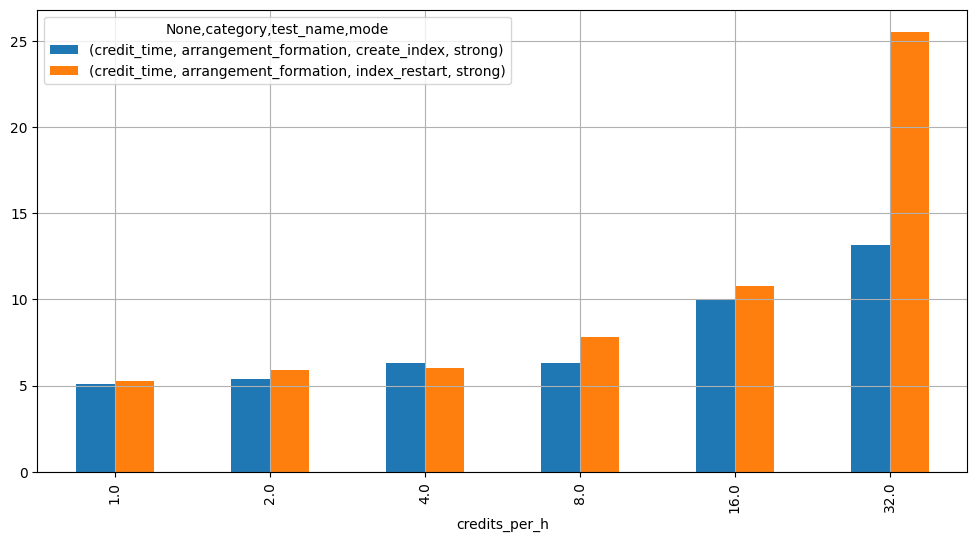

In [15]:
ax = df2.loc['tpcc_sf'].dropna(axis=1, how='all').plot(kind='bar', figsize=(12,6))

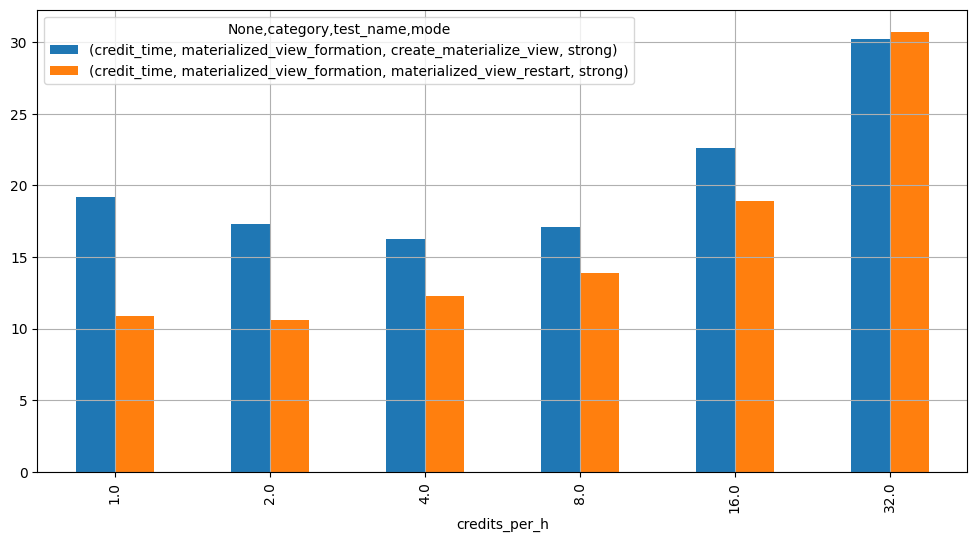

In [16]:
ax = df2.loc['tpcc_mv_sf'].dropna(axis=1, how='all').plot(kind='bar', figsize=(12,6))

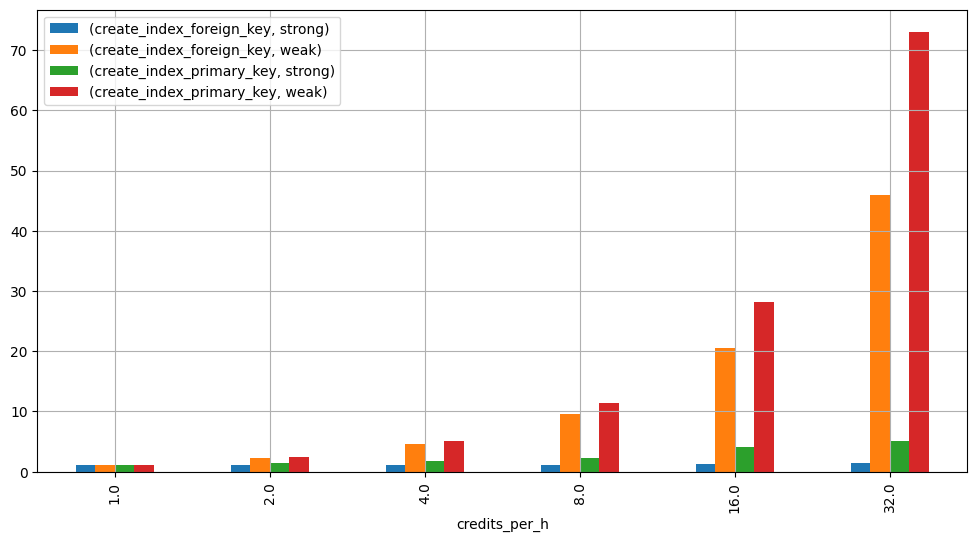

In [17]:
ax = df2.loc[('auction',), ('credit_time', 'arrangement_formation')].dropna(axis=1, how='all').plot(kind='bar', logy=False, figsize=(12,6))
ax.legend(loc='upper left', bbox_to_anchor=(0,1))

,scenario,mode,category,test_name,cluster_size,repetition,size_bytes,time_ms,scenario_name,credits_per_h,ccredit_per_s,workers,throughput_mb_per_s,throughput_mb_per_s_worker,throughput_mb_per_credit,credit_time
222,auction_40,strong,arrangement_formation,create_index_primary_key,100cc,0,1464660863,39070,auction,1.0,0.027778,2.0,35.751458,17.875729,1287.052473,1.085278
252,auction_40,strong,arrangement_formation,create_index_primary_key,200cc,0,1464204382,24676,auction,2.0,0.055556,4.0,56.588350,14.147087,1018.590292,1.370889
282,auction_40,strong,arrangement_formation,create_index_primary_key,400cc,0,1463323357,16249,auction,4.0,0.111111,8.0,85.884295,10.735537,772.958651,1.805444
312,auction_40,strong,arrangement_formation,create_index_primary_key,800cc,0,1460673449,10379,auction,8.0,0.222222,16.0,134.213966,8.388373,603.962847,2.306444
342,auction_40,strong,arrangement_formation,create_index_primary_key,1600cc,0,1454733967,9377,auction,16.0,0.444444,31.0,147.951629,4.772633,332.891164,4.167556
372,auction_40,strong,arrangement_formation,create_index_primary_key,3200cc,0,1454584117,5665,auction,32.0,0.888889,62.0,244.871935,3.949547,275.480927,5.035556


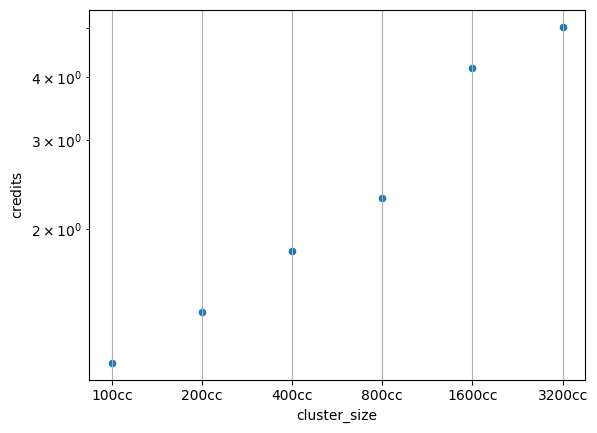

In [18]:
df2 = df[(df["mode"]=="strong") & (df["test_name"]=="create_index_primary_key")]
df2.plot(kind='scatter', x="cluster_size", y="credit_time", ylabel='$\\text{credits}$', logy=True, grid=True)
df2

,scenario,mode,category,test_name,cluster_size,repetition,size_bytes,time_ms,scenario_name,credits_per_h,ccredit_per_s,workers,throughput_mb_per_s,throughput_mb_per_s_worker,throughput_mb_per_credit,credit_time
78,tpcc_mv_sf_10,strong,materialized_view_formation,create_materialize_view,100cc,0,0,690062,tpcc_mv_sf,1.0,0.027778,2.0,0.0,0.0,0.0,19.168389
102,tpcc_mv_sf_10,strong,materialized_view_formation,create_materialize_view,200cc,0,0,311942,tpcc_mv_sf,2.0,0.055556,4.0,0.0,0.0,0.0,17.330111
126,tpcc_mv_sf_10,strong,materialized_view_formation,create_materialize_view,400cc,0,0,146459,tpcc_mv_sf,4.0,0.111111,8.0,0.0,0.0,0.0,16.273222
150,tpcc_mv_sf_10,strong,materialized_view_formation,create_materialize_view,800cc,0,0,76876,tpcc_mv_sf,8.0,0.222222,16.0,0.0,0.0,0.0,17.083556
174,tpcc_mv_sf_10,strong,materialized_view_formation,create_materialize_view,1600cc,0,0,50930,tpcc_mv_sf,16.0,0.444444,31.0,0.0,0.0,0.0,22.635556
198,tpcc_mv_sf_10,strong,materialized_view_formation,create_materialize_view,3200cc,0,0,34028,tpcc_mv_sf,32.0,0.888889,62.0,0.0,0.0,0.0,30.247111


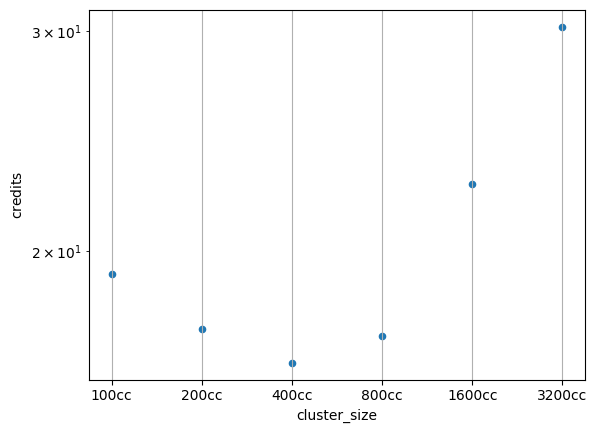

In [19]:
df2 = df[(df["mode"]=="strong") & (df["scenario"] == 'tpcc_mv_sf_10') & (df["test_name"]=="create_materialize_view")]
df2.plot(kind='scatter', x="cluster_size", y="credit_time", ylabel='$\\text{credits}$', logy=True, grid=True)
df2